In [1]:
include <- function(pkg) {
  if (!suppressMessages(require(pkg, character.only = TRUE)))
    install.packages(pkg, character.only = TRUE)
  suppressMessages(library(pkg, pkg, character.only = TRUE))
}
include("docopt")
include("stringr")
include("alakazam")
include("scoper")
include("dplyr")

In [2]:
doc <- "Usage:
  clones.R analyze_clones [--name <name>] [--threads <threads>] [--binwidth <binwidth>] [--wd <wd>][--suffix <suffix>] <tsv> 
  clones.R analyze_diversity [--name <name>] [--wd <wd>] <clones_tsv>  

  Options:   
   -w --wd <wd> [default: .]
   -n --name <name> Name of the sample
   -t --threads <threads> Number of threads [type: int] [default: 8]
   -b --binwidth Width of the bin in plotting [type: num] [default: 0.02]
   -s --suffix <suffix> [default: _with_clones].
   -h --help     Show this screen."

In [3]:
debug <- TRUE
debug_command <- "analyze_clones"  # {"analyze_clones", "analyze_diversity"}
if (debug == TRUE) {
    if (debug_command == "analyze_clones") {
        tsv <- file.path("/data", "samples", "AIRR-Seq", "OURS", "S3987Nr1", "S3987Nr1-PBMC_heavy", "changeo_igblast", "S3987Nr1-PBMC_heavy_f_parse-select_with_translation.tsv")  # 'clones', 'changeo_clone',  'our_pbmc_germ-pass.tsv')    
        args <- paste("analyze_clones --suffix _with_clones --name S3987Nr1-PBMC_heavy", tsv)
    } else if (debug_command == "analyze_diversity") {
        tsv <- file.path("/data", "samples", "AIRR-Seq", "OURS", "S3987Nr1", "S3987Nr1-PBMC_heavy", "subsamples", "sample_1000", "clones", "S3987Nr1-PBMC_heavy_with_clones.tsv")   
        args <- paste("analyze_diversity --name S3987Nr1-PBMC_heavy", tsv)   
    } else {
        stop(paste0("Debug command ", debug_command, " is not supported."))
    }
    print(args)
    values <- docopt(doc, args = args, version = "0.1")
    print(values)
} else {
    values <- docopt(doc, version = "0.1")
}

[1] "analyze_clones --suffix _with_clones --name S3987Nr1-PBMC_heavy /data/samples/AIRR-Seq/OURS/S3987Nr1/S3987Nr1-PBMC_heavy/changeo_igblast/S3987Nr1-PBMC_heavy_f_parse-select_with_translation.tsv"
List of 18
 $ --wd             : chr "."
 $ --name           : chr "S3987Nr1-PBMC_heavy"
 $ --threads        : chr "8"
 $ --binwidth       : chr "0.02"
 $ --suffix         : chr "_with_clones"
 $ --help           : logi FALSE
 $ analyze_clones   : logi TRUE
 $ <tsv>            : chr "/data/samples/AIRR-Seq/OURS/S3987Nr1/S3987Nr1-PBMC_heavy/changeo_igblast/S3987Nr1-PBMC_heavy_f_parse-select_wit"| __truncated__
 $ analyze_diversity: logi FALSE
 $ <clones_tsv>     : NULL
 $ wd               : chr "."
 $ name             : chr "S3987Nr1-PBMC_heavy"
 $ threads          : chr "8"
 $ binwidth         : chr "0.02"
 $ suffix           : chr "_with_clones"
 $ help             : logi FALSE
 $ tsv              : chr "/data/samples/AIRR-Seq/OURS/S3987Nr1/S3987Nr1-PBMC_heavy/changeo_igblast/S3987Nr1-PBMC

In [4]:
tsv <- values$tsv
name <- values$name
binwidth <- as.numeric(values$binwidth)
threads <- as.numeric(values$threads)

clones_tsv <- values$clones_tsv
analyze_clones <- values$analyze_clones
analyze_diversity <- values$analyze_diversity

In [5]:
# Helper functions
build_filepath <- function(name, suffix, type="tsv") {
    if (type %in% c("tsv", "svg")) {
        return(
            file.path(paste0(name, "_", suffix, ".", type))
        )
    } else {
        stop(paste0("Filetype ", type, " not supported."))
    }
}

writeAnalysisTable <- function(table, filepath) {
    write.table(
        table, 
        file = filepath, 
        quote = FALSE, 
        row.names = FALSE, 
        sep = "\t")
    print(paste0("Output is written to ", filepath))
}

### Spectral clone analysis ###

In [8]:
computeSpectralClones <- function(
    db, threads, verbose = TRUE) {
    
    results <- tryCatch({
            scoper::spectralClones(db, "vj", verbose = verbose, nproc = threads)
            },
            warning = function(cond) {
                iter_max_warning = 15000
                nstart_warning = 5000
                print(paste0(
                    "Warning issued. Retrying with iter_max=", iter_max_warning,
                    "; nstart=", nstart_warning
                ))
                scoper::spectralClones(
                    db,
                    "vj",
                    verbose = TRUE, 
                    iter_max = iter_max_warning,
                    nstart = nstart_warning
                )
        })
    return(results)
}

In [9]:
if (analyze_clones == TRUE) {
    db <- alakazam::readChangeoDb(tsv)

    print(paste("starting spectral analyzis with ", threads, "threads"))

    # Clonal assignment using identical nucleotide sequences
    results <- computeSpectralClones(db, threads, verbose=TRUE)

    writeAnalysisTable(results@vjl_groups, build_filepath(name, "vjl_groups", "tsv"))

    print(paste("writing spectral analyzes results", file.path(paste0(name, values$suffix, ".tsv"))))
    writeChangeoDb(results@db, file.path(paste0(name, values$suffix, ".tsv")))

    print(paste("writing spectral analyzes picture", file.path(paste0(name, values$suffix, ".svg"))))
    svg(file = paste0(name, values$suffix, ".svg"), width = 800, height = 600)
    if (binwidth > 0) {
        print(paste("binwidth is", binwidth))
      plot(results, binwidth = binwidth)
    } else plot(results)
    if (debug == TRUE) {
      dev.off()
    }
}

[1] "starting spectral analyzis with  8 threads"


Running defineClonesScoper in bulk mode



     MAX_N_FILTER>  0 invalid junction(s) ( # of N > 0 ) in the junction column removed. 
[1] "Output is written to S3987Nr1-PBMC_heavy_vjl_groups.tsv"
[1] "writing spectral analyzes results S3987Nr1-PBMC_heavy_with_clones.tsv"
[1] "writing spectral analyzes picture S3987Nr1-PBMC_heavy_with_clones.png"
[1] "binwidth is 0.02"


png 
  2

### Compute counts, abundance, diversity, coverage ###

In [8]:
computeCloneCounts <- function(clones_results, name) {
    print("Computing clonotypes counts")
    counts <- alakazam::countClones(clones_results, copy = "duplicate_count")
    writeAnalysisTable(counts, build_filepath(name, "clone_counts", "tsv"))
    return(counts)
}

computeCoverage <- function(counts) {
    
    computeCoverage_subroutine <- function(max_order, counts) {
        orders <- 1:max_order
        coverages <- sapply(
            orders,
            function(order) { alakazam::calcCoverage(counts$seq_count, order) }
        )
        return(coverages)
    }
    
    tryCatchComputeCoverage <- function(counts, env) {
        coverages <- tryCatch({
                order <- get("order", env=env)
                return(computeCoverage_subroutine(order, counts))
            },
            error=function(cond) {
                order <- get("order", env=env)
                assign("order", order-1, env=env)
                print(paste0("Attempted coverage computation with order=", order,
                             "; Encountered error: ", cond, "; Attempting with order=", order-1))
                return(tryCatchComputeCoverage(counts, env))
            }
        )
        return(coverages)
    }
    
    compute_coverage_env <- new.env()
    assign("order", 10, env=compute_coverage_env)
    coverages <- tryCatchComputeCoverage(counts, compute_coverage_env)

    order <- get("order", env=compute_coverage_env)
    df <- data.frame(1:order, coverages)
    writeAnalysisTable(df, build_filepath(name, "coverages", "tsv"))
}

plotAbundancy <- function(abundanceCurve, name, filepath, debug) {
    sample_colors <- c(`-1h` = "seagreen", `+7d` = "steelblue")
    svg(file = filepath, width = 800, height = 600)
    # Plots a rank abundance curve of the relative clonal abundances
    plot(abundanceCurve, colors = sample_colors, legend_title = name)
    if (debug == TRUE) {
      dev.off()
    }
    print(paste("abundances curve chart is written to", filepath))
    plot(abundanceCurve, colors = sample_colors, legend_title = name)  # to display in notebook
}
computeAbundancy <- function(clones_results, name, debug) {
    print("Calculates abundancy with 95% confidence interval via 200 bootstrap realizations")
    abundanceCurve <- alakazam::estimateAbundance(clones_results, ci = 0.95, nboot = 200, clone = "clone_id", progress = TRUE)
    writeAnalysisTable(abundanceCurve@abundance, build_filepath(name, "abundance_curve", "tsv"))
    plotAbundancy(abundanceCurve, name, build_filepath(name, "abundancy_curve", "svg"), debug)
    return(abundanceCurve)
}

plotDiversity <- function(diversity, filepath, debug) {
    svg(file = filepath, width = 800, height = 600)
    plot(diversity)
    if (debug == TRUE) {
      dev.off()
    }
    print(paste("diversity curve is written to", filepath))
    plot(diversity)
}
computeDiversity <- function(abundancyCurve, name, debug) {
    diversity <- alakazam::alphaDiversity(abundancyCurve)
    writeAnalysisTable(diversity@diversity, build_filepath(name, "diversity", "tsv"))
    plotDiversity(diversity, build_filepath(name, "diversity", "svg"), debug)
    return(diversity)
}

[1] "Computing clonotypes counts"
[1] "Output is written to S3987Nr1-PBMC_heavy_clone_counts.tsv"
[1] "Attempted coverage computation with order=10; Encountered error: Error in alakazam::calcCoverage(counts$seq_count, order): Cannot calculate coverage of order 4. No abundance data with count=5.\n; Attempting with order=9"
[1] "Attempted coverage computation with order=9; Encountered error: Error in alakazam::calcCoverage(counts$seq_count, order): Cannot calculate coverage of order 4. No abundance data with count=5.\n; Attempting with order=8"
[1] "Attempted coverage computation with order=8; Encountered error: Error in alakazam::calcCoverage(counts$seq_count, order): Cannot calculate coverage of order 4. No abundance data with count=5.\n; Attempting with order=7"
[1] "Attempted coverage computation with order=7; Encountered error: Error in alakazam::calcCoverage(counts$seq_count, order): Cannot calculate coverage of order 4. No abundance data with count=5.\n; Attempting with order=6"
[

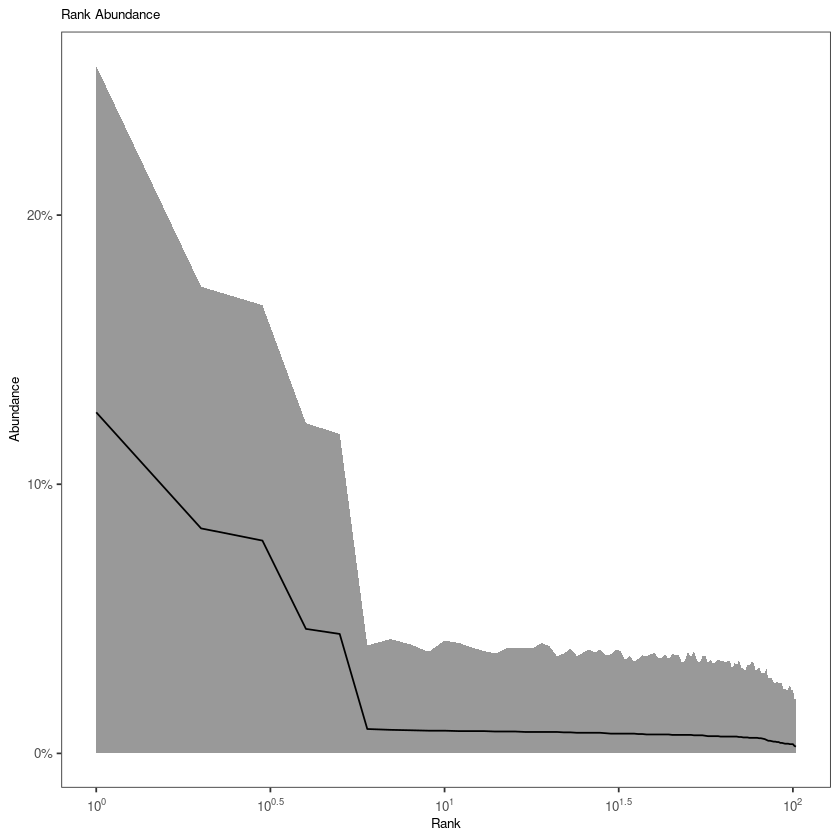

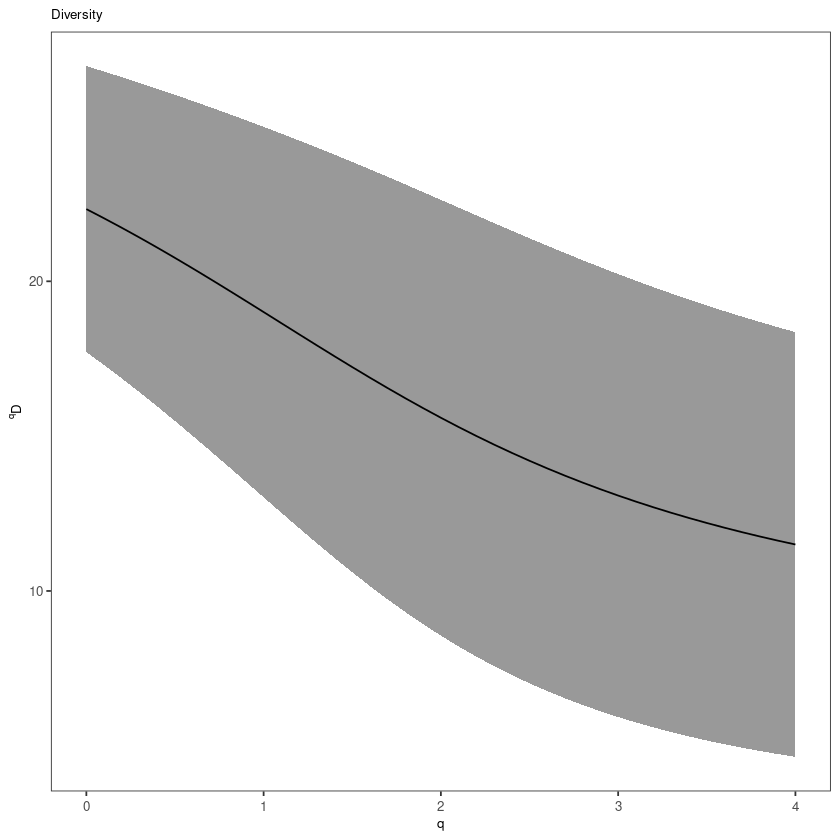

In [12]:
if (analyze_diversity == TRUE) {
    results <- alakazam::readChangeoDb(clones_tsv)
    counts <- computeCloneCounts(results, name)
    computeCoverage(counts)
    
    tryCatch({
        abundanceCurve <- computeAbundancy(results, name, debug)
        diversity <- computeDiversity(abundanceCurve, name, debug)
        },
        error = function(cond) {
            print(cond)
            print("Further execution halted.")
        }
    )
}